In [43]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import utils

In [92]:
save_path = "../data/raw/MET_simulated.npz"
seed = 42
latent_dim = 3
num_clusters = 5
category_std = 1

samples_per_cluster = 10000
cluster_std = 0.25

model_paths = {"logcpm": "../../archive/2-24/patchseq-mse/t_arm", "pca-ipfx": "../../archive/2-24/patchseq-mse/e_arm", 
          "arbors": "../../archive/2-24/patchseq-mse/m_arm", "ivscc": "../data/ivscc/m_arm_ivscc"}

In [93]:
rng = np.random.default_rng(seed)
cluster_centroids = rng.normal(0, category_std, [num_clusters, latent_dim])
latent = rng.normal(cluster_centroids[:, None], cluster_std, [num_clusters, samples_per_cluster, 3])

/var/folders/l8/m2glkk_557l1j7xyp1qbh99m0000gp/T/ipykernel_57286/583187250.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


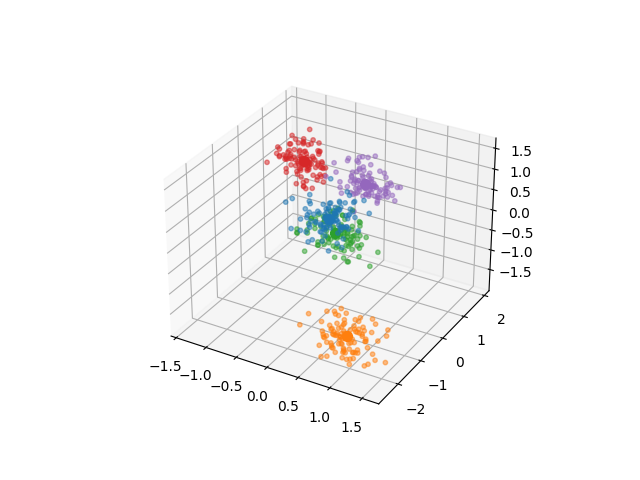

In [94]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection = "3d")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:num_clusters]
for (centroid, cluster_samples, color) in zip(cluster_centroids, latent, colors):
    ax.scatter(centroid[0], centroid[1], centroid[2], s = 50, c = color)
    points = rng.choice(cluster_samples, min(100, cluster_samples.shape[0]), replace = False)
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s = 10, c = color, alpha = 0.5)
plt.show()

In [95]:
models = {form: utils.load_jit_folds(path)["folds"][1]["best"] for (form, path) in model_paths.items()}
simulated_data = {}
for (form, model) in models.items():
    decoder = next(iter(model.values()))["dec"]
    with torch.no_grad():
        cluster_tensors = [decoder(torch.from_numpy(cluster_latent).float()) for cluster_latent in latent]
        if type(cluster_tensors[0]) == dict:
            cluster_tensors = [form_dict[form] for form_dict in cluster_tensors]
    simulated_data[form] = torch.stack(cluster_tensors).numpy()

In [96]:
num_samples = num_clusters*samples_per_cluster
labels = np.broadcast_to(np.arange(num_clusters)[:, None], (num_clusters, samples_per_cluster)).flatten().astype("str")
data_dict = {
    "specimen_id": np.arange(num_samples).astype("str"),
    "platform": np.full([num_samples], "simulated"),
    "class": np.full([num_samples], "null"),
    "cluster_label": labels,
    "latent": latent.reshape([num_samples, -1]),
    "logcpm": simulated_data["logcpm"].reshape([num_samples, -1]),
    "pca-ipfx": simulated_data["pca-ipfx"].reshape([num_samples, -1]),
    "arbors": simulated_data["arbors"].reshape([num_samples, -1]),
    "ivscc": simulated_data["ivscc"].reshape([num_samples, -1])
}
if save_path:
    np.savez_compressed(save_path, **data_dict)

In [97]:
x

In [101]:
x["class"].shape

(65697,)